# World Trade Regression — End-to-End Notebook

Goal: Predict export_value_usd_mln using multiple regression models, compare performance (MAE/RMSE/R²), and build ensembles (Voting & Stacking).

Dataset: world_trade_synth_fast.csv (columns include year, trade pair info, quantities, prices, macro indicators).

Deliverables: clean preprocessing, top models, robust evaluation, tuned models, ensemble, saved best model

#### Importing all necessary Libraries

In [24]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline


#### Loading the dataset

In [25]:
# Replace with your dataset
df = pd.read_csv("world_trade_synth_fast.csv")

print(df.shape)
df.head()


(1000000, 16)


,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,export_value_usd_mln,quantity_tonnes,unit_price_usd_per_tonne
0,1975,USA,DZA,AGRI,5273.4,0,9.23,180.484,443.922,48.765,10.598,51.95,53.25,1.703,58.330,29191.463644
1,1975,USA,DZA,ENER,5273.4,0,14.81,180.484,443.922,48.765,10.598,51.95,53.25,2.213,75.814,29191.463644
2,1975,USA,DZA,META,5273.4,0,9.57,180.484,443.922,48.765,10.598,51.95,53.25,0.883,30.262,29191.463644
3,1975,USA,DZA,CHEM,5273.4,0,9.15,180.484,443.922,48.765,10.598,51.95,53.25,4.917,168.447,29191.463644
4,1975,USA,DZA,MACH,5273.4,0,3.99,180.484,443.922,48.765,10.598,51.95,53.25,15.236,521.919,29191.463644


## Exploratory Data Analysis.

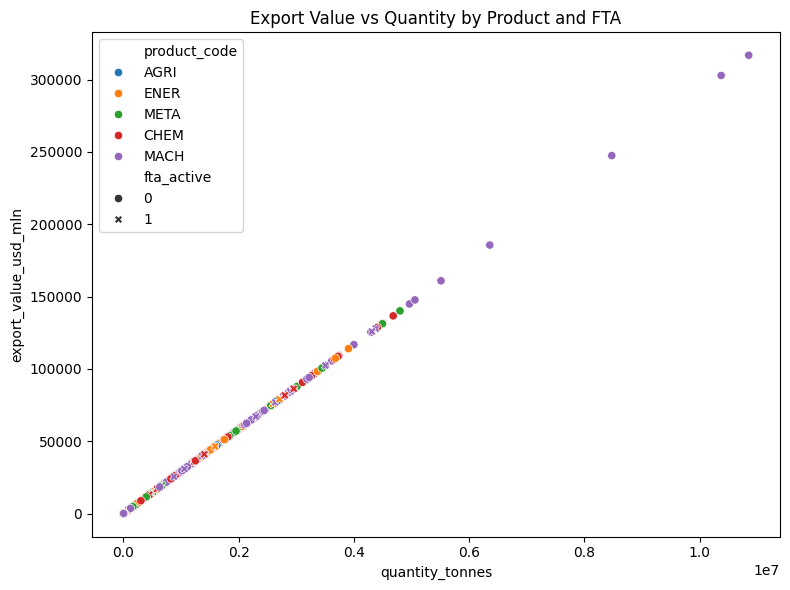

In [31]:
# 1. Scatter plot: Export Value by Quantity (color by Product)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='quantity_tonnes', y='export_value_usd_mln', hue='product_code', style='fta_active')
plt.title("Export Value vs Quantity by Product and FTA")
plt.tight_layout()
plt.show()

C:\Users\meher\AppData\Local\Temp\ipykernel_39732\685780865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='product_code', y='unit_price_usd_per_tonne', data=df, inner='quartile', palette='muted')


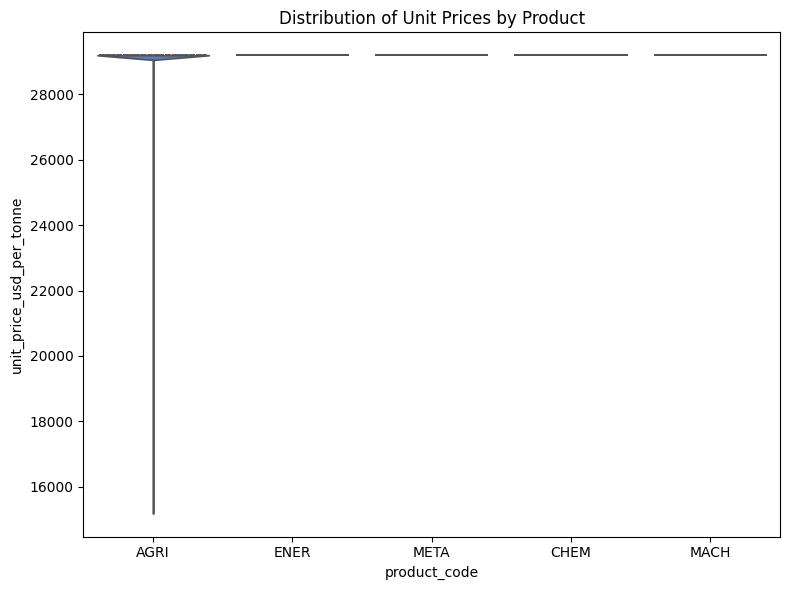

In [32]:
# 2. Distribution: Unit Price per Tonne by Product
plt.figure(figsize=(8, 6))
sns.violinplot(x='product_code', y='unit_price_usd_per_tonne', data=df, inner='quartile', palette='muted')
plt.title("Distribution of Unit Prices by Product")
plt.tight_layout()
plt.show()

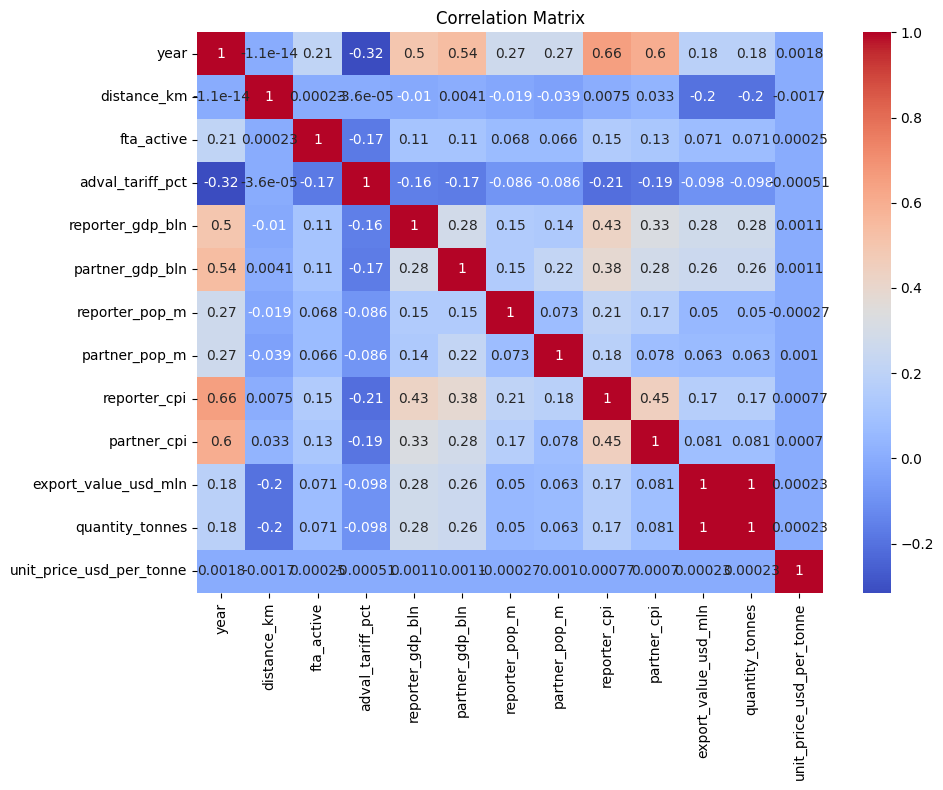

In [33]:
# 3. Heatmap: Correlation Matrix (only numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

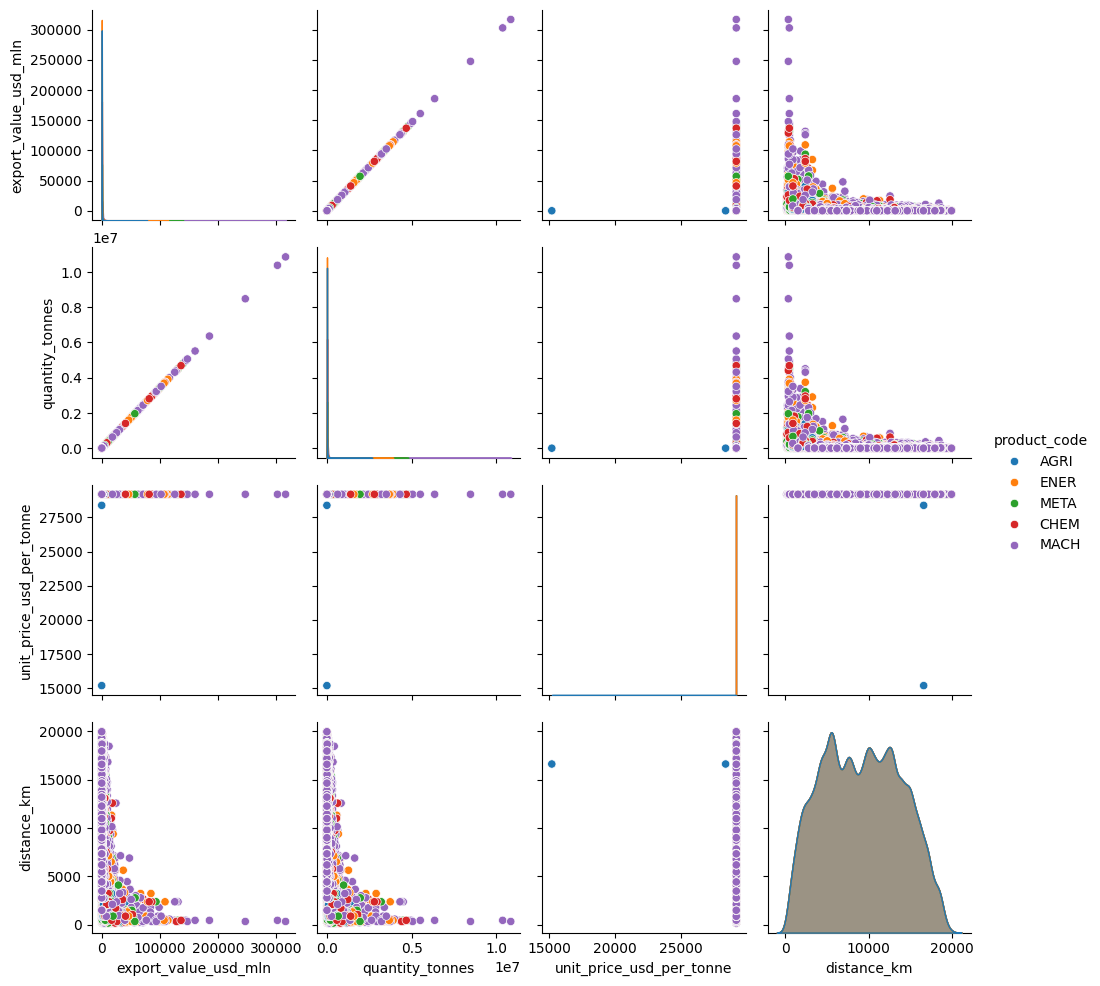

In [34]:
# 4. Pairplot: Key Variables (colored by Product)
sns.pairplot(df, vars=['export_value_usd_mln','quantity_tonnes','unit_price_usd_per_tonne','distance_km'], hue='product_code')
plt.show()

In [ ]:
# 5. Boxplot: Ad Valorem Tariff Percent by Reporter
plt.figure(figsize=(10, 6))
sns.boxplot(x='reporter_iso3', y='adval_tariff_pct', data=df)
plt.title('Ad Valorem Tariff Distribution by Reporter')
plt.tight_layout()
plt.show()

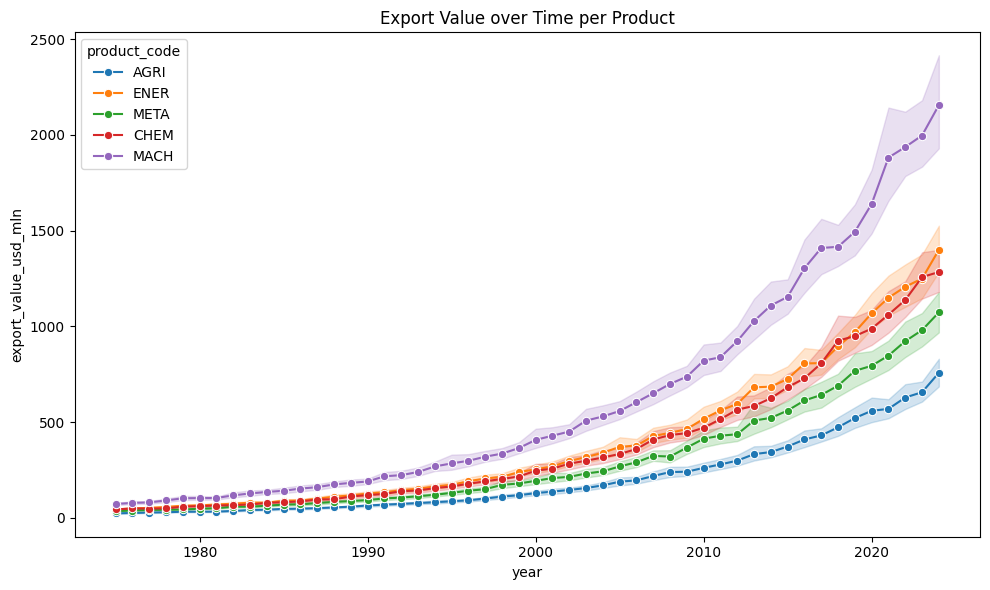

In [35]:
# 6. Linechart: Export Value over Years by Product
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='export_value_usd_mln', hue='product_code', marker='o')
plt.title("Export Value over Time per Product")
plt.tight_layout()
plt.show()

C:\Users\meher\AppData\Local\Temp\ipykernel_39732\1759778072.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='reporter_iso3', y='unit_price_usd_per_tonne', estimator='mean', ci='sd')


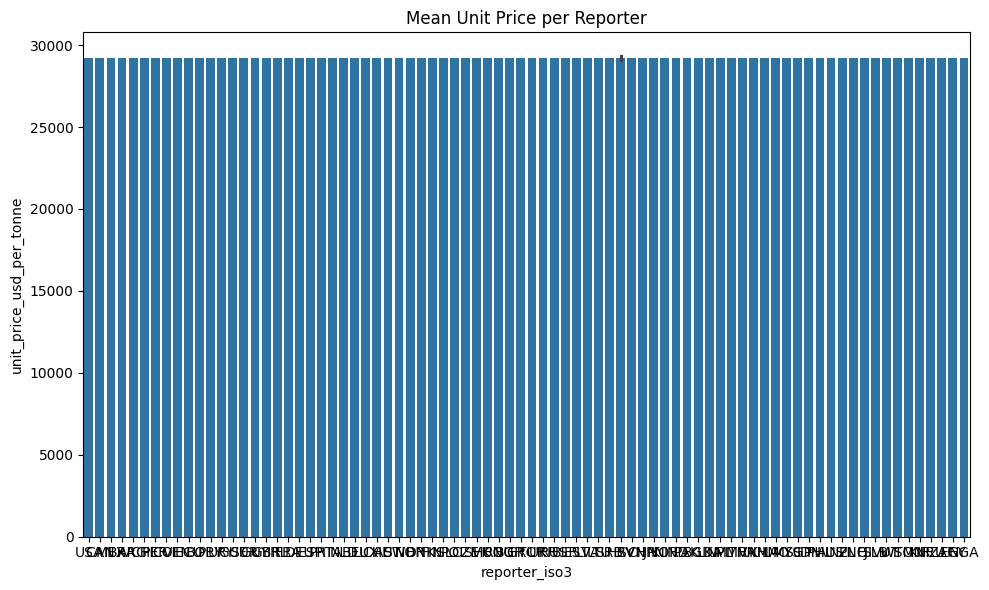

In [36]:
# 7. Barplot: Mean Unit Price per Reporter
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='reporter_iso3', y='unit_price_usd_per_tonne', estimator='mean', ci='sd')
plt.title("Mean Unit Price per Reporter")
plt.tight_layout()
plt.show()

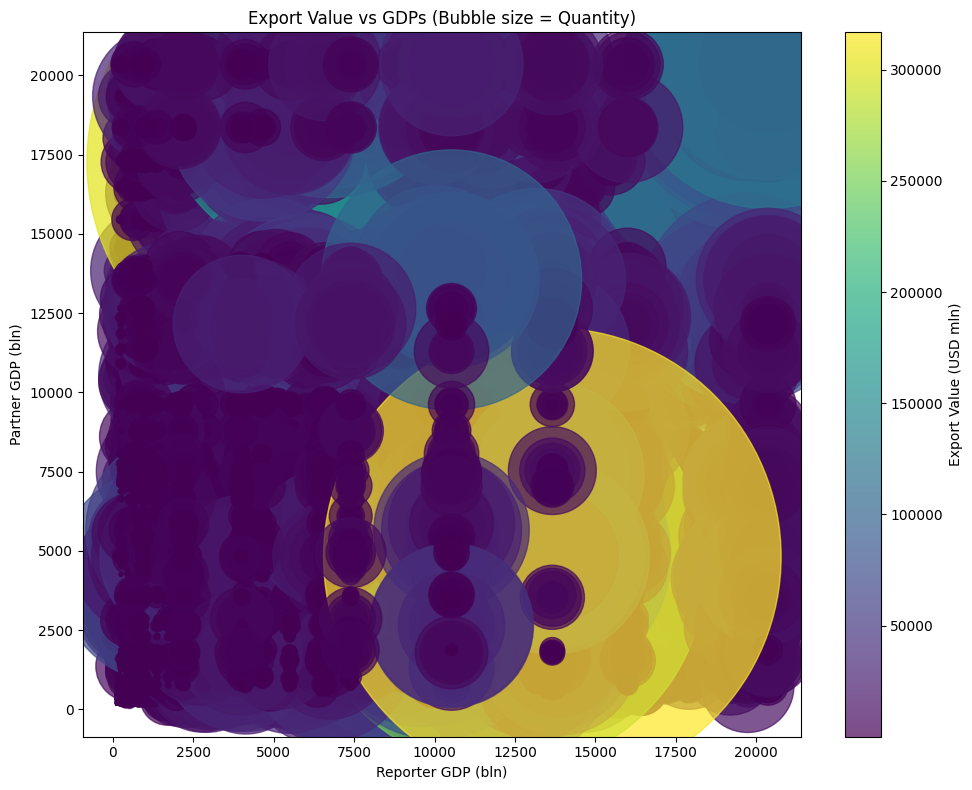

In [37]:
# 8. Bubble Chart: Export Value vs GDP (Reporter and Partner, bubble size=Quantity)
plt.figure(figsize=(10, 8))
plt.scatter(df['reporter_gdp_bln'], df['partner_gdp_bln'], s=df['quantity_tonnes']/100, c=df['export_value_usd_mln'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Export Value (USD mln)')
plt.xlabel('Reporter GDP (bln)')
plt.ylabel('Partner GDP (bln)')
plt.title('Export Value vs GDPs (Bubble size = Quantity)')
plt.tight_layout()
plt.show()

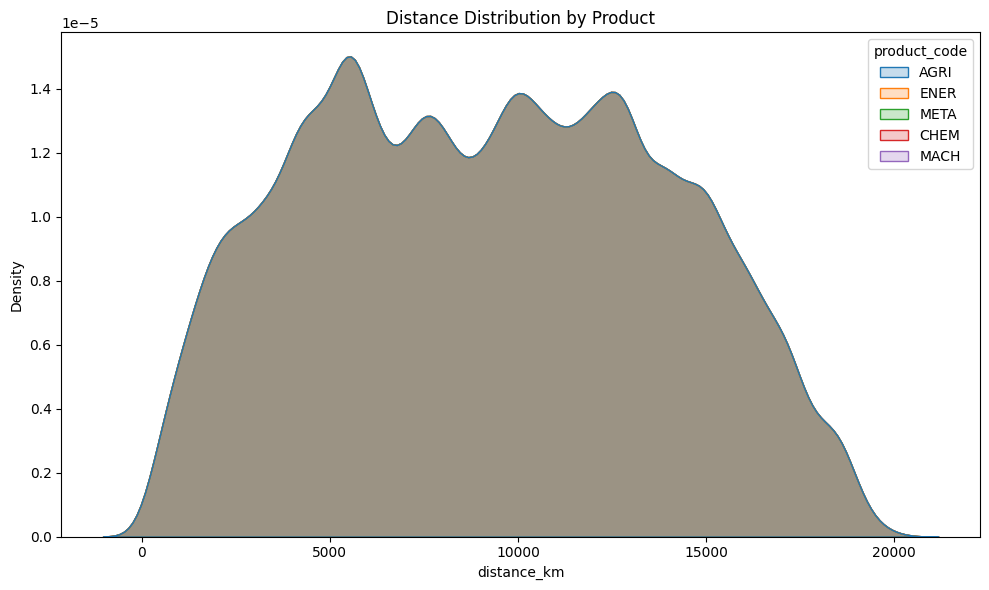

In [38]:
# 9. KDE Plot: Distance Distribution (by Product)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='distance_km', hue='product_code', fill=True)
plt.title("Distance Distribution by Product")
plt.tight_layout()
plt.show()

In [ ]:
# # 10. Swarmplot: FTA Active vs Unit Price (by Product)
# plt.figure(figsize=(10, 6))
# sns.swarmplot(data=df, x='fta_active', y='unit_price_usd_per_tonne', hue='product_code')
# plt.title("Unit Price by FTA Status and Product")
# plt.tight_layout()
# plt.show()

KeyboardInterrupt: 

#### Train - test split.

In [26]:
# Suppose 'target' is the column we want to predict
target_col = "export_value_usd_mln"  # <-- replace with your column name
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Feature Engineering

#### Detect categorical and numerical features

In [27]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessor: OneHot for categorical, Scale for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [30]:
df.head()

,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,export_value_usd_mln,quantity_tonnes,unit_price_usd_per_tonne
0,1975,USA,DZA,AGRI,5273.4,0,9.23,180.484,443.922,48.765,10.598,51.95,53.25,1.703,58.330,29191.463644
1,1975,USA,DZA,ENER,5273.4,0,14.81,180.484,443.922,48.765,10.598,51.95,53.25,2.213,75.814,29191.463644
2,1975,USA,DZA,META,5273.4,0,9.57,180.484,443.922,48.765,10.598,51.95,53.25,0.883,30.262,29191.463644
3,1975,USA,DZA,CHEM,5273.4,0,9.15,180.484,443.922,48.765,10.598,51.95,53.25,4.917,168.447,29191.463644
4,1975,USA,DZA,MACH,5273.4,0,3.99,180.484,443.922,48.765,10.598,51.95,53.25,15.236,521.919,29191.463644


#### Defining Models

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42)
}


#### Train & Evaluate Models

In [29]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # safe for sparse matrices
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
results_df


ValueError: could not convert string to float: 'AUT'

#### Visualization of Results

In [ ]:
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison (Regression)")
plt.ylabel("Error / Score")
plt.xticks(rotation=45)
plt.show()


#### Stacking Ensemble

In [ ]:
estimators = [
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('hgb', HistGradientBoostingRegressor(random_state=42))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(n_estimators=200, random_state=42)
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

stack_results = {
    "RMSE": mean_squared_error(y_test, y_pred_stack, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "R2": r2_score(y_test, y_pred_stack)
}

print("Stacking Model Performance:", stack_results)


In [ ]:
import warnings, os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore") # keep notebook tidy

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["figure.dpi"] = 120

DATA_PATH = "./world_trade_synth_fast.csv" # <-- adjust if needed
OUTDIR = Path("./nb_artifacts")
OUTDIR.mkdir(parents=True, exist_ok=True)